# What is the Customer Lifetime Value (CLTV) ?

    The present value of the future cash flows attributed to the customer during his/her entire relationship with the company.

In marketing, CLTV, LCV, or LTV is a prognostication of the net profit contributed to the whole future relationship with a customer. The prediction model can have varying levels of sophistication and accuracy, ranging from a crude heuristic to the use of complex predictive analytics techniques.

Another definition about CLV, sometimes referred to as LTV, is the profit margin a company expects to earn over the entirety of their business relationship with the average customer.

The CLV value must account for CAC, ongoing sales and marketing expenses, operating expenses, and, of course, the cost required to manufacture the product and services the company is selling.

Many companies take a short-sighted approach by overlooking this valuable metric and instead optimize for a single sale in the near term. It’s still important to find new customers for the growth of the company, but optimizing the lifetime value of existing customers is also essential for a company to sustain a viable business model.

In fact, an increase in customer retention rates by only 5% has been found to increase profits anywhere from 25% to 95%. With this in mind, increasing the expected CLV is essential.

Note: I usually will use some abbreviated words below:

    Customer Lifetime Value — CLTV or CLV
    Lifetime Customer Value — LCV
    Life Time Value — LTV
    Customer Acquisition Costs — CAC

### If you want to get more detailed information about the subject, I recommend you to read the Medium article series below.
https://mathchi.medium.com/customer-lifetime-value-clv-or-cltv-cd6f7232b764

In order to understand this notebook better, I will write tasks and try to explain the codes by giving the answers to the questions. Lets start...

### CLTV in 4 Steps

- 1. Data Preperation
- 2. Calculate Expected Sale Forecasting values with BG-NBD Model.
- 3. Calculate Expected Average Profit values with Gamma-Gamma Model.
- 4. Calculate CLTV for a specified time period with BG-NBD and Gamma-Gamma models.


#### Let's remember the preceding formula:
     CLTV = (Customer_Value / Churn_Rate) * Profit_margin.
     Customer_Value = Average_Order_Value * Purchase_Frequency
     

## FURTHER PROJECT PURPOSE: Estimate CLTV using BGNBD and GammaGamma Models.

### MISSION 1

- Predict 6-month CLTV for 2010-2011 UK customers.
- Comment your results and evaluate them.
- Highlight results that you think are irrational or too accurate.
- Attention! We expect cltv prediction, not 6 months expected sales.
- So continue by directly installing bgnbd and gamma models and
- For CLTV prediction, enter 6 in the month section.

### 1. Data Preperation


In [15]:
import datetime as dt

import pandas as pd
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit       # burayi (freq > 1) oldugundan pasiflestirdik. negatif degil pozitif yonlu aykiriliktan 
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


df_ = pd.read_excel("online_retail_II.xlsx",
                    sheet_name="Year 2010-2011")

df = df_.copy()
df = df[df["Country"] == "United Kingdom"]
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")
df["TotalPrice"] = df["Quantity"] * df["Price"]

today_date = dt.datetime(2011, 12, 11)



### RFM Table Preperation

In [16]:
## recency kullanıcıya özel dinamik.
rfm = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                     lambda date: (today_date - date.min()).days],
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

rfm.columns = rfm.columns.droplevel(0)

## recency_cltv_p
rfm.columns = ['recency_cltv_p', 'T', 'frequency', 'monetary']        # T is Tenure (Age of the Customer)

## basitleştirilmiş monetary_avg
rfm["monetary"] = rfm["monetary"] / rfm["frequency"]

rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)

### Calculating Weekly Recency and Weekly T for BGNBD

In [17]:
# BGNBD için WEEKLY RECENCY VE WEEKLY T'nin HESAPLANMASI

## recency_weekly_p
rfm["recency_weekly_p"] = rfm["recency_cltv_p"] / 7
rfm["T_weekly"] = rfm["T"] / 7

# KONTROL
rfm = rfm[rfm["monetary_avg"] > 0]

## freq > 1
rfm = rfm[(rfm['frequency'] > 1)]
rfm["frequency"] = rfm["frequency"].astype(int)   

### 2. BG/NBD Model Establishment

In [18]:
# pip install lifetimes

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(rfm['frequency'],
        rfm['recency_weekly_p'],
        rfm['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.12, alpha: 11.66, b: 2.51, r: 2.21>

#### Who are the top 10 customers we expect to buy in 1 week?

In [19]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        rfm['frequency'],
                                                        rfm['recency_weekly_p'],
                                                        rfm['T_weekly']).sort_values(ascending=False).head(10)

rfm["expected_number_of_purchases"] = bgf.predict(1,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12747.00000,366,370,11,381.45545,52.28571,52.85714,0.20248
12748.00000,372,374,210,153.82814,53.14286,53.42857,3.25295
12749.00000,209,214,5,814.48800,29.85714,30.57143,0.16715
12820.00000,323,327,4,235.58500,46.14286,46.71429,0.10397
12822.00000,16,88,2,474.44000,2.28571,12.57143,0.12914


#### Who are the top 10 customers we expect to buy in 1 month?

In [20]:
bgf.predict(4,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sort_values(ascending=False).head(10)

rfm["expected_number_of_purchases"] = bgf.predict(4,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

rfm.sort_values("expected_number_of_purchases", ascending=False).head(20)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12748.00000,372,374,210,153.82814,53.14286,53.42857,12.97752
17841.00000,371,374,124,328.82234,53.00000,53.42857,7.71259
13089.00000,366,370,97,605.18660,52.28571,52.85714,6.11174
14606.00000,372,374,93,129.96161,53.14286,53.42857,5.81976
15311.00000,373,374,91,667.59681,53.28571,53.42857,5.69939
12971.00000,368,373,86,127.04983,52.57143,53.28571,5.39472
13408.00000,371,374,62,453.28194,53.00000,53.42857,3.92123
18102.00000,366,368,60,3584.88775,52.28571,52.57143,3.85079
13798.00000,370,373,57,650.51114,52.85714,53.28571,3.62330


#### What is the Expected Sales of the whole Company in 1 Month?

In [21]:
bgf.predict(4,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()

1597.273267103235

#### What is the Expected Sales of the Whole Company in 3 Months?

In [22]:
bgf.predict(4 * 3,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()

4738.999309834784

#### Evaluating Forecast Results

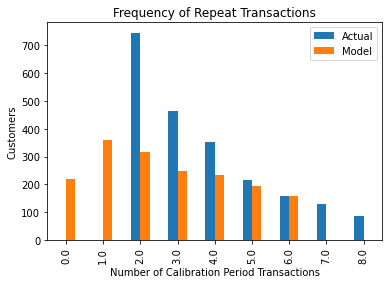

In [23]:
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)
plt.show()

### 3. GAMMA-GAMMA Model Establishment

In [24]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm['frequency'], rfm['monetary_avg'])

ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).head(10)

ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).sort_values(ascending=False).head(10)

rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                         rfm['monetary_avg'])

rfm.sort_values("expected_average_profit", ascending=False).head(20)


,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit
Customer ID,,,,,,,,
14088.00000,312,323,13,3859.60154,44.57143,46.14286,1.03575,3911.31885
18102.00000,366,368,60,3584.88775,52.28571,52.57143,3.85079,3595.19256
14096.00000,97,102,17,3159.07706,13.85714,14.57143,2.87354,3191.38673
17511.00000,370,374,31,2921.95194,52.85714,53.42857,2.02407,2938.27449
15749.00000,97,333,3,2521.44667,13.85714,47.57143,0.11316,2675.11900
17450.00000,359,368,46,2629.52989,51.28571,52.57143,2.97227,2639.41934
13081.00000,359,372,11,2575.62273,51.28571,53.14286,0.80158,2616.62439
16984.00000,41,131,2,2240.67500,5.85714,18.71429,0.41069,2452.12491
16000.00000,0,3,3,2055.78667,0.00000,0.42857,1.64094,2181.32360


### 4. Calculation of CLTV with BG/NBD and GG models

In [25]:
cltv = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv.head()

cltv.shape
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(50)
rfm_cltv_final = rfm.merge(cltv, on="Customer ID", how="left")
rfm_cltv_final.head()

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12747.00000,366,370,11,381.45545,52.28571,52.85714,0.80768,387.82285,992.91591
1,12748.00000,372,374,210,153.82814,53.14286,53.42857,12.97752,153.97132,6336.06664
2,12749.00000,209,214,5,814.48800,29.85714,30.57143,0.66573,844.09470,1774.24621
3,12820.00000,323,327,4,235.58500,46.14286,46.71429,0.41457,247.08095,324.33897
4,12822.00000,16,88,2,474.44000,2.28571,12.57143,0.51265,520.82819,836.49377


### MISSION 2

- Calculate 1-month and 12-month CLTV for 2010-2011 UK customers.
- Analyze the top 10 people in 1 month CLTV and the top 10 people in 12 months.
- Is there a difference? If yes, why do you think?
(Hint: It is possible to calculate directly cltv over the available bgf and ggf here.)


In [26]:
# CLTV calculate 1-month and 12-month

cltv1 = ggf.customer_lifetime_value(bgf,
                                    rfm['frequency'],
                                    rfm['recency_weekly_p'],
                                    rfm['T_weekly'],
                                    rfm['monetary_avg'],
                                    time=1,                 # months
                                    freq="W",               # T weekly
                                    discount_rate=0.01)

rfm_cltv1_final = rfm.merge(cltv1, on="Customer ID", how="left")
rfm_cltv1_final.sort_values(by="clv", ascending=False).head()

cltv12 = ggf.customer_lifetime_value(bgf,
                                     rfm['frequency'],
                                     rfm['recency_weekly_p'],
                                     rfm['T_weekly'],
                                     rfm['monetary_avg'],
                                     time=12,                # months
                                     freq="W",               # T weekly
                                     discount_rate=0.01)

rfm_cltv12_final = rfm.merge(cltv12, on="Customer ID", how="left")
rfm_cltv12_final.head()

rfm_cltv1_final.sort_values("clv", ascending=False).head(10)
rfm_cltv12_final.sort_values("clv", ascending=False).head(10)


,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
Customer ID,,,,,,,,,
18102.00000,366,368,60,3584.88775,52.28571,52.57143,3.85079,3595.19256,163591.12676
14096.00000,97,102,17,3159.07706,13.85714,14.57143,2.87354,3191.38673,104900.44292
17450.00000,359,368,46,2629.52989,51.28571,52.57143,2.97227,2639.41934,92694.27482
17511.00000,370,374,31,2921.95194,52.85714,53.42857,2.02407,2938.27449,70285.65230
16684.00000,353,359,28,2120.04696,50.42857,51.28571,1.90146,2133.20359,47890.36421
13694.00000,369,374,50,1267.36260,52.71429,53.42857,3.18452,1271.78540,47871.90000
14088.00000,312,323,13,3859.60154,44.57143,46.14286,1.03575,3911.31885,47688.86365
15311.00000,373,374,91,667.59681,53.28571,53.42857,5.69939,668.89446,45067.80939
13089.00000,366,370,97,605.18660,52.28571,52.85714,6.11174,606.29366,43795.47286


### MISSION 3

- For 2010-2011 UK customers, divide all your customers into 3 groups (segments) according to 6-month CLTV and
- Add the group names to the data set. For example (Premium, Gold, Silver)
- Analyze the 3 groups in terms of other variables in the data set.
- Offer 6-month action recommendations to management for 3 groups.

In [27]:
cltv = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=6,                 # months
                                   freq="W",               # T weekly
                                   discount_rate=0.01)

rfm_cltv_final = rfm.merge(cltv, on="Customer ID", how="left")
rfm_cltv_final.head()

rfm_cltv_final["cltv_segment"] = pd.qcut(rfm_cltv_final["clv"], 3, labels=["C", "B", "A"])
rfm_cltv_final.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv,cltv_segment
Customer ID,,,,,,,,,,
12747.00000,366,370,11,381.45545,52.28571,52.85714,0.80768,387.82285,1937.04614,A
12748.00000,372,374,210,153.82814,53.14286,53.42857,12.97752,153.97132,12365.79618,A
12749.00000,209,214,5,814.48800,29.85714,30.57143,0.66573,844.09470,3446.01044,A
12820.00000,323,327,4,235.58500,46.14286,46.71429,0.41457,247.08095,631.93933,B
12822.00000,16,88,2,474.44000,2.28571,12.57143,0.51265,520.82819,1612.09665,A


Lets check with sort_value function. If clv number is high then it must Premium!

In [28]:
rfm_cltv_final.sort_values("clv", ascending=False).head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv,cltv_segment
Customer ID,,,,,,,,,,
18102.00000,366,368,60,3584.88775,52.28571,52.57143,3.85079,3595.19256,85651.01047,A
14096.00000,97,102,17,3159.07706,13.85714,14.57143,2.87354,3191.38673,55650.64677,A
17450.00000,359,368,46,2629.52989,51.28571,52.57143,2.97227,2639.41934,48533.31011,A
17511.00000,370,374,31,2921.95194,52.85714,53.42857,2.02407,2938.27449,36797.00673,A
16684.00000,353,359,28,2120.04696,50.42857,51.28571,1.90146,2133.20359,25083.02541,A



## Conclusion

#### What keeps a customer coming back?

Customers are gained and lost over the lifetime of any company, but a truly great product or service can keep customers well fed, yet still hungry for more — figuratively speaking. This appetite for more is what continuously adds value to the company over the span of their relationship with customers.

- What happens next? If we ask ourselves, we can get the answer:

- Benchmarks should be made according to time with the Holdout method.

    After this notebook, my aim is try to further develop my other works.

    If you have any suggestions, please could you write for me? I wil be happy for comment and critics!

    Thank you for your suggestion and votes ;)



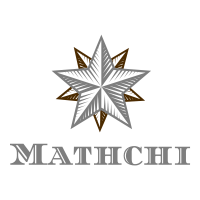

In [29]:
from IPython.display import Image
Image("C:/Users/gebruiker/Downloads/mathchi1.png")